In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import os
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import random
from torchvision.utils import make_grid
from tqdm import tqdm
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d
import torchvision.models as models
from IPython.display import clear_output
# from utils import gradient_penalty

In [2]:
lr = 5e-4
batch_size = 64
image_size = 64
# image_size = 128
# image_size = 130
in_channels = 3
z_dim = 100
epochs = 3000
features_disc = 64
features_gen = 64
dropout = 0
critic_iter = 5
lambda_gp = 10
# weight_clip = 0.01

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
dir = "../../Shoes-Dataset-Colored/"
batch_size = 64

In [5]:
# class CustomRotate:
#     def __init__(self, degrees, fill=(255, 255, 255)):
#         self.degrees = degrees
#         self.fill = fill

#     def __call__(self, img):
#         # Convert PIL image to numpy array
#         img_np = np.array(img)
#         # Rotate the image
#         rotated_img = Image.fromarray(np.uint8(img_np)).rotate(self.degrees, fillcolor=self.fill)
#         return rotated_img

In [6]:
# rotate_probability = 0.4 

In [7]:
# def conditional_rotation(image):
#     if random.random() < rotate_probability:
#         return CustomRotate(degrees=random.randint(0,225))(image)
#     else:
#         return image

In [8]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),             
    # transforms.Lambda(conditional_rotation),  # Conditional rotation
    # transforms.ColorJitter(brightness=0.2,         
    #                        saturation=0,
    #                        contrast=0,
    #                        hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5 for _ in range(in_channels)], [0.5 for _ in range(in_channels)])
])
footwear = datasets.ImageFolder(root=dir, transform=transform)
mapping = footwear.class_to_idx
mapping

{'Boot': 0, 'Sandal': 1, 'Shoe': 2}

In [9]:
train_loader = DataLoader(footwear, batch_size=batch_size, shuffle=True, drop_last=True)

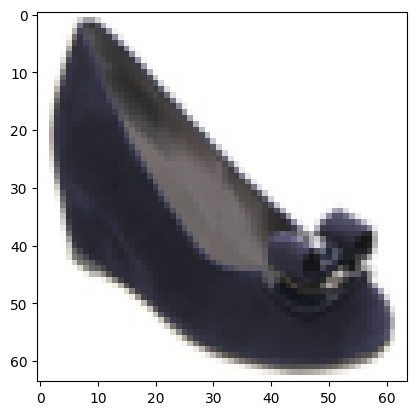

In [10]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    # height, width = image_grid.shape[1:]
    # figure_size = (width/50) , (height/50)
    # plt.figure(figsize=figure_size)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()
    

show_tensor_images(next(iter(train_loader))[0], num_images=1)

In [11]:
class Critic(nn.Module):
    
    def __init__(self, channel_imgs, features_d, num_of_classes, img_size, dropout_prob) -> None:
        super(Critic, self).__init__()
        # Input shape will be N x channel_imgs x 64x64
        self.img_size = img_size
        self.dropout_prob = dropout_prob
        self.critic = nn.Sequential(
            
            nn.Conv2d(channel_imgs+1, features_d, kernel_size=4, stride=2, padding=1), # 32x32
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4, 2, 1), # 16x16
            self._block(features_d*2, features_d*4, 4, 2, 1), # 8x8
            self._block(features_d*4, features_d*8, 4, 2, 1), # 4x4
            nn.Conv2d(features_d*8, out_channels= 1, kernel_size=4, stride=2, padding=1), # 1 x 1
            
        )
        self.embedding = nn.Embedding(num_of_classes, img_size * img_size)
    
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )
        
    def forward(self, x, labels):
        embedding = self.embedding(labels).view(labels.shape[0], 1, self.img_size, self.img_size)
        x = torch.cat([x, embedding], dim=1)
        return self.critic(x)

In [12]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g, num_classes, img_size, embed_size, dropout_prob = 0.5) -> None:
        super(Generator, self).__init__()
        self.img_size = img_size
        self.dropout_prob = dropout_prob
        self.generator = nn.Sequential(
            # Input: N x z_dim x 1x1
            self._block(z_dim + embed_size, features_g*16, 4, 1, 0), # N x features_g*16 x 4x4 
            self._block(features_g*16, features_g*8, 4, 2, 1),  # N x features_g*8 x 8x8
            self._block(features_g*8, features_g*4, 4, 2, 1),  # N x features_g*4 x 16x16
            self._block(features_g*4, features_g*2, 4, 2, 1),  # N x features_g*2 x 32x32
            nn.ConvTranspose2d(features_g*2, channels_img, kernel_size=4, stride=2, padding=1), # N x channels_img x 64x64
            nn.Tanh(), # [-1, 1]       
        )
        self.embedding = nn.Embedding(num_classes, embed_size)
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding), # deconvolution
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    def forward(self, x, labels):
        embedding = self.embedding(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([x, embedding], dim=1)
        
        return self.generator(x)

In [13]:
def intialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [14]:
def gradient_penalty(critic, labels,real, fake, device="cuda"):
    batch_size, C, H, W = real.shape
    epsilon = torch.rand((batch_size, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * epsilon + fake * (1 - epsilon)
    
    mixed_scores = critic(interpolated_images, labels)
    
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    
    return gradient_penalty

In [15]:
num_classes = 3
gen_embed = 100
# gen_embed = 512

In [16]:
gen = Generator(z_dim, in_channels, features_gen, num_classes, image_size, gen_embed, dropout_prob= dropout).to(device)
critic = Critic(in_channels, features_disc, num_classes, image_size, dropout_prob= dropout).to(device)
intialize_weights(gen)
intialize_weights(critic)
# opt_gen = optim.RMSprop(gen.parameters(), lr=lr)
# opt_critic = optim.RMSprop(critic.parameters(), lr=lr)

opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=lr, betas=(0.0, 0.9))

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The generator has {count_parameters(gen):,} trainable parameters')
print(f'The critic has {count_parameters(critic):,} trainable parameters')

The generator has 14,299,055 trainable parameters
The critic has 2,779,841 trainable parameters


In [17]:
fixed_noise = torch.randn(32, z_dim, 1, 1)
writer_real = SummaryWriter(f"logs/real")
write_fake = SummaryWriter(f"logs/fake")
step = 0

In [18]:
# gen.load_state_dict(torch.load("./model_500/gen_500.pth"))
# disc.load_state_dict(torch.load("./model_500/disc_500.pth"))

In [19]:
gen.train()

Generator(
  (generator): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(200, 1024, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding

In [20]:
critic.train()

Critic(
  (critic): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (embedding): Embedding(3, 4096)
)

In [21]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()

c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [23]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [24]:
def calculate_fretchet(images_real,images_fake,model):
     mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
     mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    
     """get fretched distance"""
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value

In [25]:
# # This Cell Can be modified many times according to where the model stopped training
gen.load_state_dict(torch.load("./WGANS-GP-2_lr_2e-4/WGANS-GP-2_400/gen_400.pth"))
critic.load_state_dict(torch.load("./WGANS-GP-2_lr_2e-4/WGANS-GP-2_400/critic_400.pth"))
opt_critic.load_state_dict(torch.load("./WGANS-GP-2_lr_2e-4/WGANS-GP-2_400/opt_critic_400.pth"))
opt_gen.load_state_dict(torch.load("./WGANS-GP-2_lr_2e-4/WGANS-GP-2_400/opt_gen_400.pth"))
loss_critic = torch.load("./WGANS-GP-2_lr_2e-4/WGANS-GP-2_400/losses_critic.pth")
loss_gen = torch.load("./WGANS-GP-2_lr_2e-4/WGANS-GP-2_400/losses_gen.pth")
fid_scores_prev = torch.load("./WGANS-GP-2_lr_2e-4/WGANS-GP-2_400/fid_scores.pth")

In [161]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
def sharpen_image(image):
    kernel = np.array([[-1, -1, -1],
                       [-1, 9, -1],
                       [-1, -1, -1]])
    return cv2.filter2D(image, -1, kernel)

(102, 136, 3)


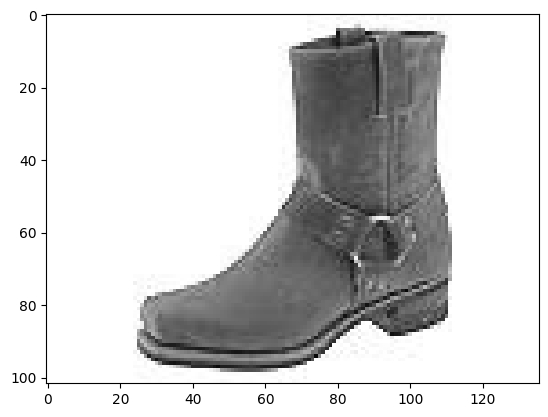

In [179]:
# visualize this image boot (1).jpg
img = cv2.imread("boot (1).jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
plt.imshow(img)

torch.Size([1])
torch.Size([1, 3, 64, 64])
torch.Size([3, 64, 64])
1


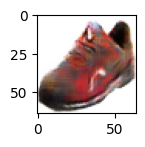

In [549]:
gen.load_state_dict(torch.load("./WGANS-GP-3_/WGANS-GP-3_700/gen_700.pth"))
gen.cpu()

gen.eval()

# infere some images
label = torch.tensor([2], device="cpu").repeat(1)
print(label.size())
noise = torch.randn(1, z_dim, 1, 1, device="cpu")
fake = gen(noise, label)
print(fake.size())
# Assuming fake is your image tensor
fake_normalized = (fake * 255).clamp(0, 255).to(torch.uint8)  # Normalize to [0, 255]

print(fake[0].size())

# fake_sharpend = sharpen_image(fake[0].cpu().detach().numpy().transpose(1, 2, 0))
# print(fake_sharpend.shape)
# # plt.figure(figsize=(100,10))
# plt.imshow(fake_sharpend)
print(fake.shape[0])
show_tensor_images(fake,num_images=fake.shape[0] ,size=(3, 64, 64))

In [26]:
start_epoch = 400
step = 0
losses_critic = loss_critic
losses_gen = loss_gen
fid_scores = fid_scores_prev

for epoch in range(start_epoch, epochs):
    tqdm_train_loader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch_idx, (real, labels) in enumerate(tqdm_train_loader):
        labels = labels.to(device)
        real = real.to(device)
        cur_batch_size = real.shape[0]
        for _ in range(critic_iter):
            noise = torch.randn(cur_batch_size, z_dim, 1, 1).to(device)
            fake = gen(noise, labels).to(device)
            critic_real = critic(real, labels).reshape(-1)
            critic_fake = critic(fake, labels).reshape(-1)
            gp = gradient_penalty(critic, labels, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + lambda_gp * gp # <- remove lambda_gp if not using WGAN-GP
                )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()
        
        losses_critic.append(loss_critic.item())

        # for p in critic.parameters():
        #     p.data.clamp_(-weight_clip, weight_clip)
            
        
        ## Train Generator: min -E[critic(gen_fake)]
        output = critic(fake, labels).reshape(-1)
        loss_gen = -torch.mean(output)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        losses_gen.append(loss_gen.item())

        # Update progress bar description
        tqdm_train_loader.set_postfix({"Loss D": loss_critic.item(), "Loss G": loss_gen.item()})

        if batch_idx % 100 == 0:
            tqdm_train_loader.write(
                f"Epoch [{epoch+1}/{epochs}] Batch {batch_idx}/{len(train_loader)} Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(noise, labels)
                img_grid_real = make_grid(real[:32], normalize=True)
                img_grid_fake = make_grid(fake[:32], normalize=True)
                writer_real.add_image("Real", img_grid_real, global_step=step)
                write_fake.add_image("Fake", img_grid_fake, global_step=step)
                step += 1

    # Visualize and print losses after each epoch
    plt.figure(figsize=(10, 5))
    plt.plot(losses_critic, label='Critic Loss')
    plt.plot(losses_gen, label='Generator Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(f'Epoch {epoch+1}/{epochs}: Critic and Generator Losses')
    plt.legend()
    os.makedirs("images/loss", exist_ok=True)
    plt.savefig(f"images/loss/loss{epoch+1}.png")
    plt.close()
    # Calculate and visualize FID every epoch
    with torch.no_grad():
        fake = gen(noise, labels)
        fid = calculate_fretchet(real, fake, model)
        fid_scores.append(fid)

        # Visualize FID
        plt.figure(figsize=(10, 5))
        plt.plot(range(epoch + 1), fid_scores, label='FID')
        plt.xlabel('Epoch')
        plt.ylabel('FID')
        plt.title('FID Score')
        plt.legend()
        os.makedirs("images/fid", exist_ok=True)
        plt.savefig(f"images/fid/fid{epoch+1}.png")
        plt.close()

        # Print FID score
        print(f"Epoch [{epoch+1}/{epochs}] FID: {fid:.4f}")

    if (epoch+1) % 1 == 0 or epoch == 0:
            gen.eval()
            noise = torch.randn(32, z_dim, 1, 1).to(device)
            fake = gen(noise, labels[:32])
            img_grid_fake = make_grid(fake[:32], normalize=True)
            plt.imshow(img_grid_fake.permute(1, 2, 0).cpu().numpy())
            os.makedirs("images/fake", exist_ok=True)
            plt.savefig(f"images/fake/fake{epoch+1}.png")
            plt.close()

    # Save evaluation metrics, generator, Critic, and optimizers every 50 epochs
    if (epoch + 1) % 50 == 0:
        os.makedirs(f"WGANS-GP-3_/WGANS-GP-3_{epoch+1}", exist_ok=True)
        
        # Visualize FID
        plt.figure(figsize=(10, 5))
        plt.plot(range(epoch + 1), fid_scores, label='FID')
        plt.xlabel('Epoch')
        plt.ylabel('FID')
        plt.title('FID Score')
        plt.legend()
        plt.savefig(f"WGANS-GP-3_/WGANS-GP-3_{epoch+1}/fid_plot.png")
        plt.close()
        
        plt.figure(figsize=(10, 5))
        plt.plot(losses_critic, label='Critic Loss')
        plt.plot(losses_gen, label='Generator Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title(f'Epoch {epoch+1}/{epochs}: Critic and Generator Losses')
        plt.legend()
        plt.savefig(f"WGANS-GP-3_/WGANS-GP-3_{epoch+1}/losses_plot.png")  
        
        plt.imsave(f"WGANS-GP-3_/WGANS-GP-3_{epoch+1}/fake_{epoch+1}.png", img_grid_fake.permute(1, 2, 0).cpu().numpy())
        plt.close()
        # Save evaluation metrics
        evaluation_metrics = {"FID": fid_scores[-1]}
        torch.save(evaluation_metrics, f"WGANS-GP-3_/WGANS-GP-3_{epoch+1}/evaluation_metrics.pth")

        # Save generator, Critic, and optimizers
        torch.save(gen.state_dict(), f"WGANS-GP-3_/WGANS-GP-3_{epoch+1}/gen_{epoch+1}.pth")
        torch.save(critic.state_dict(), f"WGANS-GP-3_/WGANS-GP-3_{epoch+1}/critic_{epoch+1}.pth")
        torch.save(opt_gen.state_dict(), f"WGANS-GP-3_/WGANS-GP-3_{epoch+1}/opt_gen_{epoch+1}.pth")
        torch.save(opt_critic.state_dict(), f"WGANS-GP-3_/WGANS-GP-3_{epoch+1}/opt_critic_{epoch+1}.pth")

        # Save losses and evaluation scores to files
        torch.save(losses_critic, f"WGANS-GP-3_/WGANS-GP-3_{epoch+1}/losses_critic.pth")
        torch.save(losses_gen, f"WGANS-GP-3_/WGANS-GP-3_{epoch+1}/losses_gen.pth")
        torch.save(fid_scores, f"WGANS-GP-3_/WGANS-GP-3_{epoch+1}/fid_scores.pth")
    if (epoch+1) %25 == 0:
        clear_output()
    gen.train()


Epoch 701/3000:   0%|          | 1/503 [00:00<06:57,  1.20it/s, Loss D=-1.19, Loss G=87.2]

Epoch [701/3000] Batch 0/503 Loss D: -1.1920, loss G: 87.2335


Epoch 701/3000:  10%|▉         | 48/503 [00:24<03:56,  1.92it/s, Loss D=-.881, Loss G=88.8]


KeyboardInterrupt: 

In [ ]:
torch.cuda.empty_cache()